<img src="ublogo.png"/>

# CSE474/574 - Introduction to Machine Learning

  - Python Demonstrations
  - Instructor - Varun Chandola


In [4]:
from sklearn import linear_model
from scipy.stats import t,laplace,norm,multivariate_normal
import numpy as np
from math import sqrt
from sklearn import model_selection
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)
from mpl_toolkits import mplot3d
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline

# Building a linear machine learning model for prediction

Let us assume we are building a model that can infer the daily number of flu-cases in the United States, using the number of tweets posted on Twitter containing the keyword `flu` during that day.

Consider the following training data (assume that the number are in 10000s):

In [13]:
df = pd.read_csv('../data/flu1d.csv')
df

,#numtweets,#numflucases
0,12,19
1,28,25
2,15,21
3,48,31
4,56,32


Now we are interested in training a model, such that it can infer the the number of flu cases for a new day, based on the number of relevant tweets.


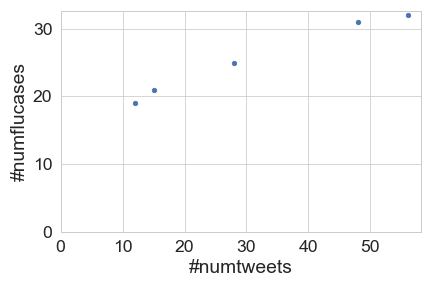

In [14]:
# plot the data
ax = df.plot.scatter(x='#numtweets',y='#numflucases',c='b')
ax.set_ylim(0,)
ax.set_xlim(0,)
plt.tight_layout()

# Mapping Objective Functions
First thing we will talk about is to "visualize" an objective function.

Consider the squared loss function discussed in class:

$$
J(w_0,w) = \frac{1}{2}\sum_{i=1}^N(y_i - (w_0 + wx_i))^2
$$

In [15]:
# convert data to a np array
X = np.array(df['#numtweets'])
y = np.array(df['#numflucases'])

In [16]:
def objfunction(w,w0,X,y):
    J = 0.5*np.sum((y - (w*X + w0))**2)
    return J

In [31]:
# compute the objective function for a range of values for w and w0
ws = np.linspace(-4, 4, 50)
w0s = np.linspace(-50, 50, 50)
W, W0 = np.meshgrid(ws, w0s)
Js = []
for w,w0 in zip(W.flatten(),W0.flatten()):
    Js.append(objfunction(w,w0,X,y))

Js = np.array(Js)
Js = np.reshape(Js,(len(ws),len(w0s)))    

In [32]:
cs = 'Rainbow'
fig = go.Figure(data=[go.Surface(z=Js, x=W, y=W0,
                                 contours = {"x": {"show": True},
                                             "y": {"show": True}
                                            },
                                 showscale=False,
                                 colorscale=cs
                                )])
fig.update_traces(contours_x=dict(show=True, usecolormap=True,project_x=True))
fig.update_traces(contours_y=dict(show=True, usecolormap=True,project_y=True))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,project_z=True))
fig.update_layout(title='Loss function', autosize=False,
                  width=500, height=500,
                  #scene = dict(zaxis=dict(range=[-3,3])),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [16]:
def objfunction_l1(w,w0,X,y):
    J = np.sum(np.abs(y - (w*X + w0)))
    return J

In [11]:
def objfunction_l0(w,w0,X,y):
    J = len(np.where(y == (w*X + w0))[0])
    return J

### Boston Housing Data

| Num | Feature   | Description |
| --- | --------- | ------------ | 
|1. | CRIM     |per capita crime rate by town |
|2. |ZN        |proportion of residential land zoned for lots over 25,000 sq.ft.|
|3. |INDUS     |proportion of non-retail business acres per town|
|4. |CHAS      |Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)|
|5. |NOX       |nitric oxides concentration (parts per 10 million)|
|6. |RM        |average number of rooms per dwelling|
|7. |AGE       |proportion of owner-occupied units built prior to 1940|
|8. |DIS       |weighted distances to five Boston employment centres|
|9. |RAD       |index of accessibility to radial highways|
|10. |TAX      |full-value property-tax rate per 10,000|
|11. |PTRATIO  |pupil-teacher ratio by town|
|12. |B        |$1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town|
|13. |LSTAT    |\% lower status of the population|
|14. |MEDV     |Median value of owner-occupied homes in \$1000's|

In [121]:
boston_data = load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Fitting a linear regression model on Boston data set
Which features to use?

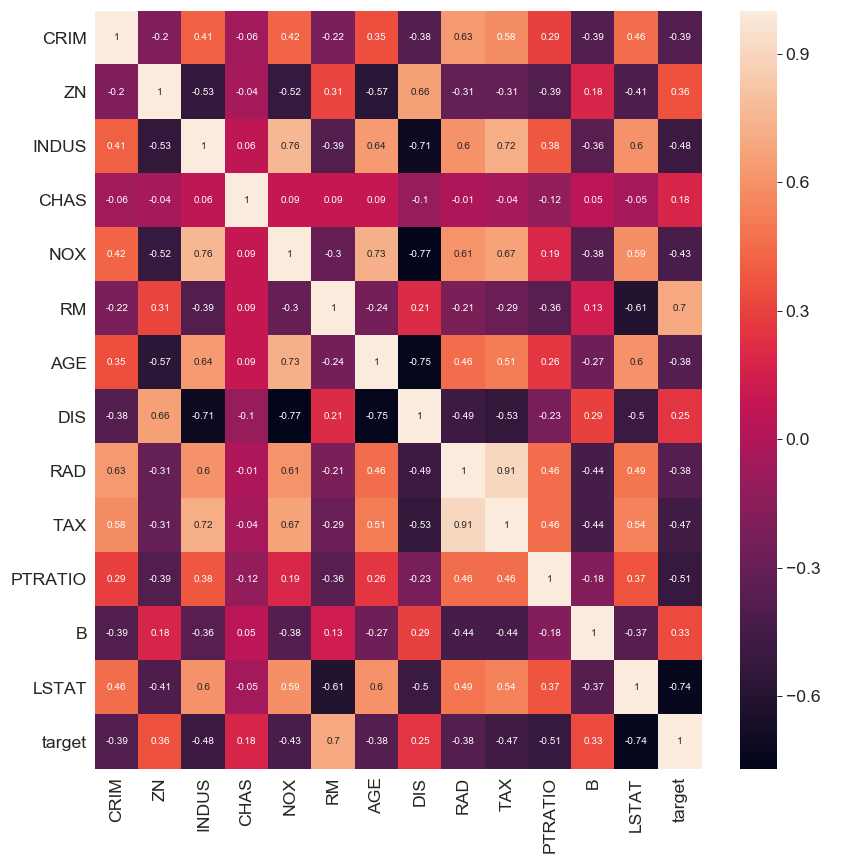

In [75]:
correlation_matrix = df_boston.corr().round(2)
# annot = True to print the values inside the square
fig = plt.figure(figsize=(12,12))
ax = sns.heatmap(data=correlation_matrix, annot=True)
plt.tight_layout()

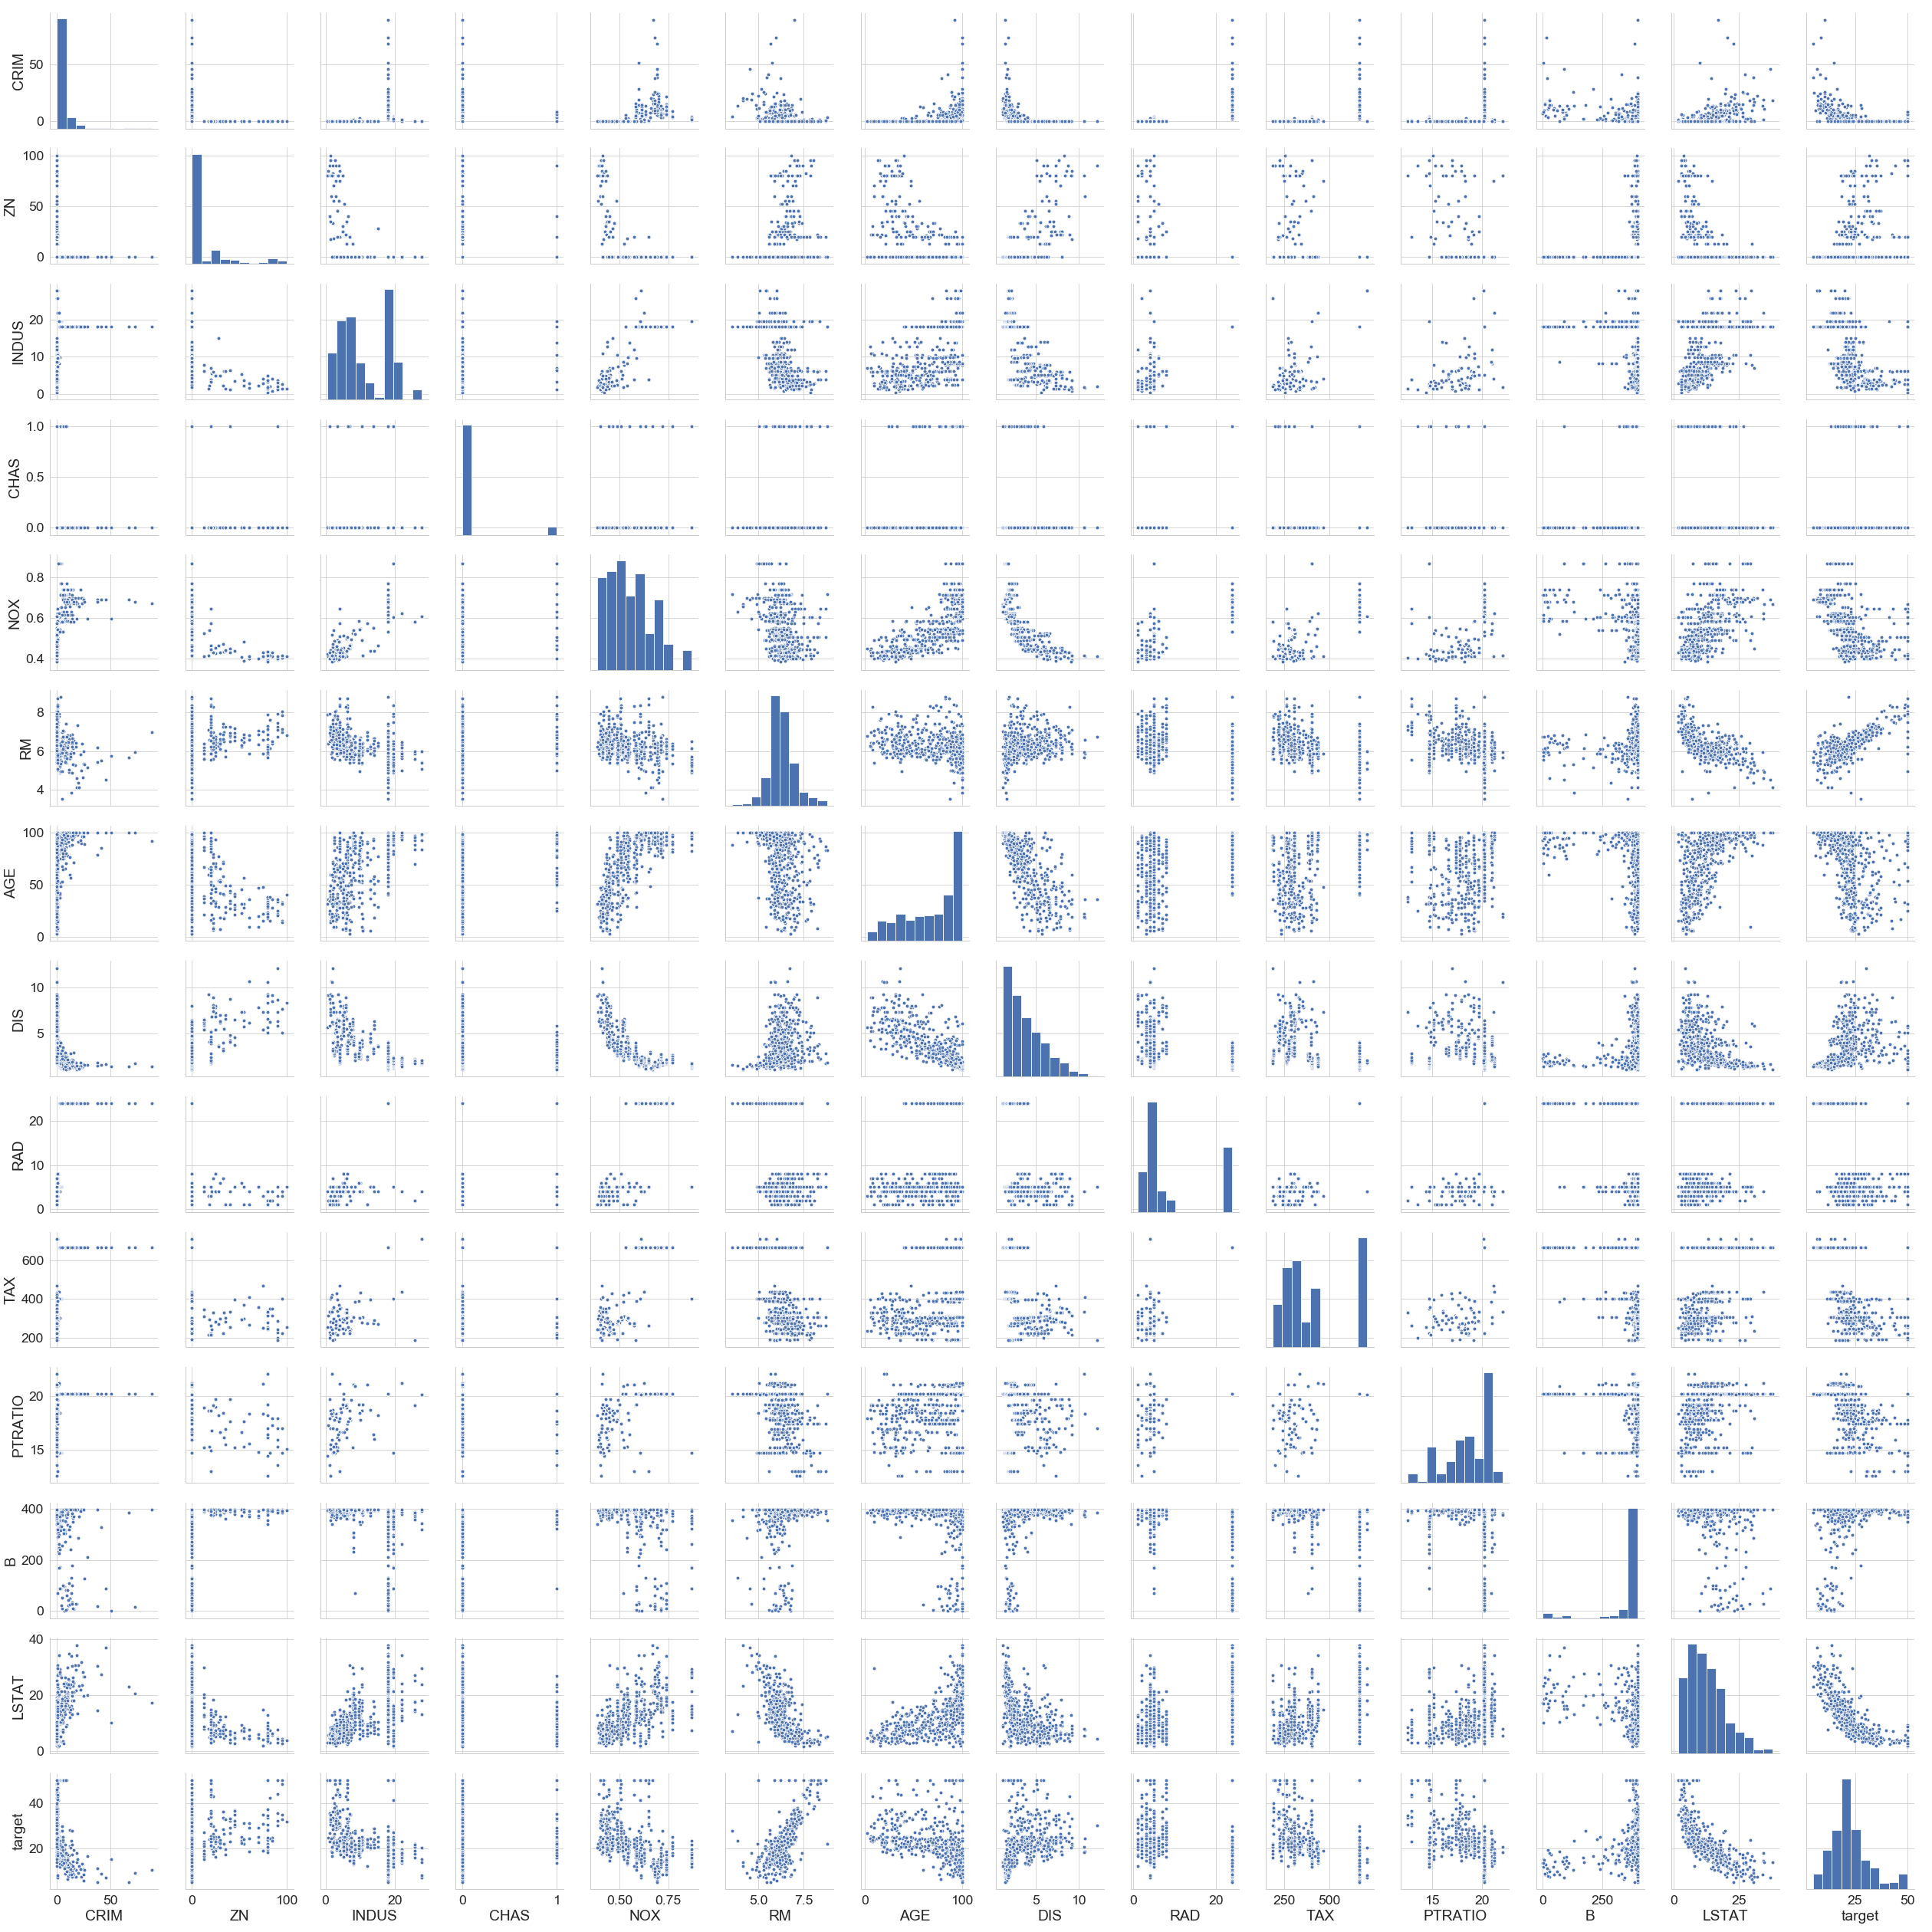

In [77]:
sns.pairplot(df_boston, vars = df_boston.columns)

Generally, you want to use features that are strongly correlated with the target (correlation closer to +1 or -1), e.g., LSTAT, RM. Here, we will simply use all of the features.


In [125]:
X = df_boston[df_boston.columns[:-1]]
y = df_boston['target']

lmodel = LinearRegression(normalize=True)
lmodel.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [126]:
lmodel.coef_

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

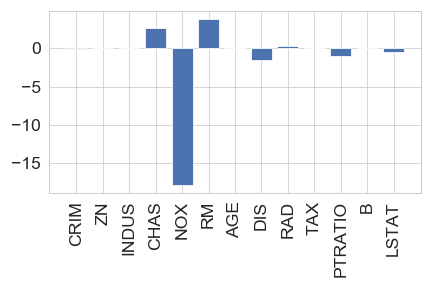

In [127]:
plt.bar(df_boston.columns[:-1],lmodel.coef_)
plt.xticks(rotation='vertical')
plt.tight_layout()

In [114]:
lmodel.intercept_

36.45948838509015

#### Importance of intercept
What happens if out model did not have an intercept, i.e., we are forcing the hyper-plane to go through the origin?

We are going to check if having an intercept impacts the accuracy of the model. This is where we introduce the notion of training error vs. generalization error.

In [95]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=5)

In [107]:
lmodel = LinearRegression()
lmodel.fit(X_train,y_train)

y_test_predicted = lmodel.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
print('RMSE on testing data with intercept is {}'.format(rmse))

RMSE on testing data with intercept is 4.568292042303176


In [108]:
lmodel = LinearRegression(fit_intercept=False)
lmodel.fit(X_train,y_train)

y_test_predicted = lmodel.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predicted)))
print('RMSE on testing data without intercept is {}'.format(rmse))

RMSE on testing data without intercept is 4.7703947977558245


Having no intercept makes the model less accurate

### Numerical instability

In [151]:
X = np.array([[1,3,4,7],[1,4,2,6],[1,8,-3,5],[1,4,7,11],[1,3,2,5]])
print(X)
y = np.array([5,2,3,9,7])
print(y)

[[ 1  3  4  7]
 [ 1  4  2  6]
 [ 1  8 -3  5]
 [ 1  4  7 11]
 [ 1  3  2  5]]
[5 2 3 9 7]


$X^\top X$

In [152]:
np.dot(X.transpose(),X)

array([[  5,  22,  12,  34],
       [ 22, 114,  30, 144],
       [ 12,  30,  82, 112],
       [ 34, 144, 112, 256]])

In [129]:
np.linalg.inv(np.dot(X.transpose(),X))

LinAlgError: Singular matrix

The above experiment shows that if your data has redundancy (repeating values), the inverse of the $X^\top X$ matrix will be unstable. However, if you use `sklearn` LinearRegression implementation, you will still see a valid solution (See below).

> Why?

In [153]:
lmodel = LinearRegression(fit_intercept=False)
lmodel.fit(X,y)
print(lmodel.coef_)

[ 2.19433198 -0.0242915   0.3562753   0.33198381]


### Gradient Descent

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $w_0$ <br>
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> <br>
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(w_k)$ <br>
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $w_{k+1} = w_k + \eta s_k$ <br>
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

In [155]:
def f(x):
    return x**3-2*x**2+2

In [156]:
def f_prime(x):
    return 3*x**2-4*x

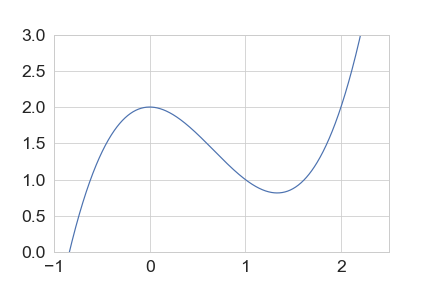

In [157]:
x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

In [158]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
n_k = 0.1 # step size
precision = 0.0001

x_list, y_list = [x_new], [f(x_new)]
while abs(x_new - x_old) > precision:
    x_old = x_new
    s_k = -f_prime(x_old)
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f(x_new))


Text(0.5, 1.0, 'Gradient descent')

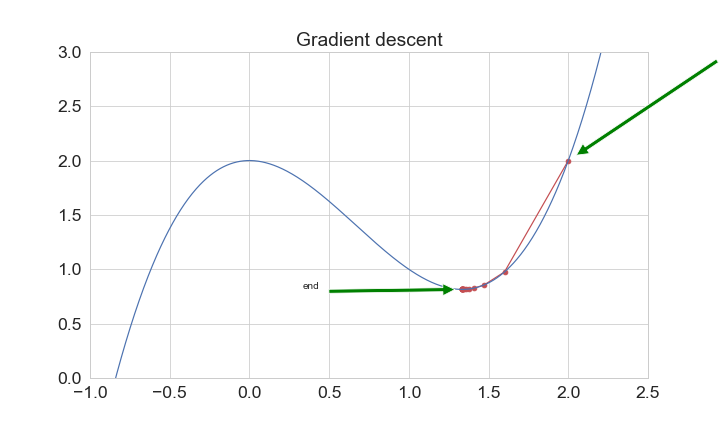

In [159]:
plt.figure(figsize=[10,6])
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.annotate(xy=(x_list[0],f(x_list[0])),
             xytext=(x_list[0]+1,f(x_list[0])+1),
             s='start',
             arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate(xy=(x_list[-1],f(x_list[-1])),
             xytext=(x_list[-1]-1,f(x_list[-1])),
             s='end',
             arrowprops=dict(facecolor='green', shrink=0.05),)
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")

Consider another function:
$$
f(x,y) = 5\cos(x - 2) + 5\sin(x - 2y)
$$
The derivative of this function will be:
$$
\nabla f = \left[\begin{array}{c}-5\sin(x-2) + 5\cos(x - 2y) \\ -10\cos(x-2y) \end{array}\right]
$$

In [160]:
def f2(x,y):
    return 5*np.cos(x -2) + 5*np.sin(x - 2*y)

In [161]:
def f2_prime(x,y):
    return np.array([-5*np.sin(x -2) + 5*np.cos(x - 2*y),-10*np.cos(x-2*y)])

In [162]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)

X, Y = np.meshgrid(x, y)
Z = f2(X, Y)

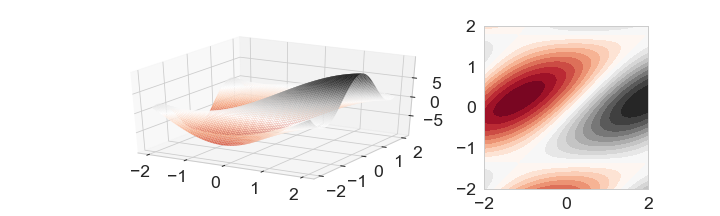

In [163]:
fig = plt.figure(figsize=(10,3))
grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0,0:2],projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='RdGy', edgecolor='none')
ax = fig.add_subplot(grid[0,2:])
ax.contourf(X, Y, Z, 20, cmap='RdGy')


In [149]:
x_old = np.array([0,0])
x_new = np.array([1,1]) 
n_k = 0.01 # step size
precision = 0.0001

x_list, y_list = [x_new], [f2(x_new[0],x_new[1])]
while np.sum(np.abs(x_new - x_old)) > precision:
    x_old = x_new
    s_k = -f2_prime(x_old[0],x_old[1])
    x_new = x_old + n_k * s_k
    x_list.append(x_new)
    y_list.append(f2(x_new[0],x_new[1]))
x_list = np.array(x_list)
y_list = np.array(y_list)

Text(-0.14008960309241303, 1.2155307727877627, 'end')

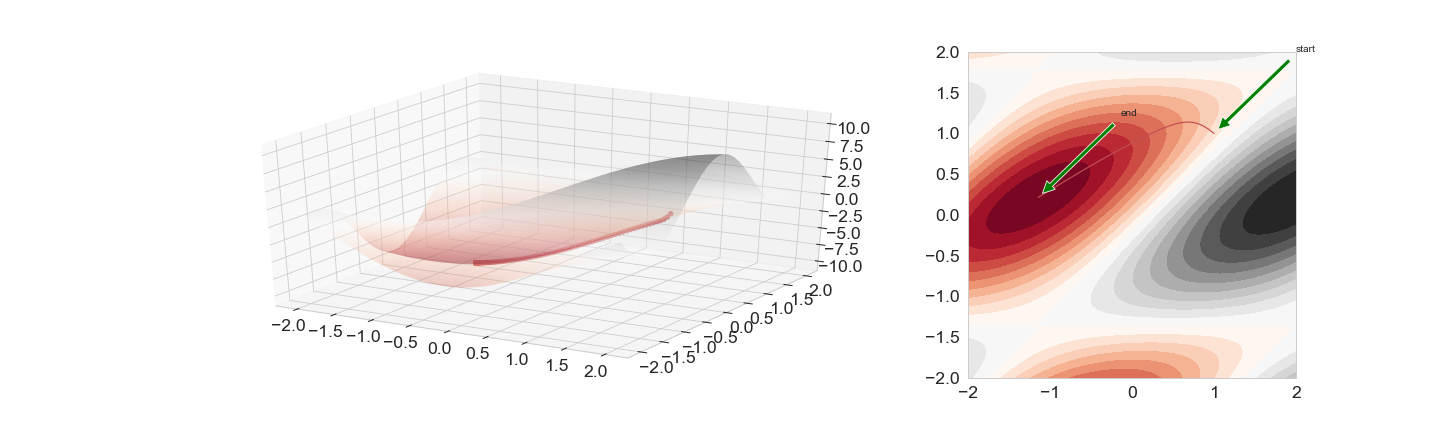

In [150]:
fig = plt.figure(figsize=(20,6))
grid = plt.GridSpec(1, 3, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0,0:2],projection='3d')
ax.plot(x_list[:,0],x_list[:,1],y_list,c="r")
ax.scatter(x_list[:,0],x_list[:,1],y_list,c="r")
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='RdGy', edgecolor='none',alpha=0.3)

ax = fig.add_subplot(grid[0,2:])
mp=ax.contourf(X, Y, Z, 20, cmap='RdGy')
ax.plot(x_list[:,0],x_list[:,1],c="r")
ax.annotate(xy=(x_list[0,0],x_list[0,1]),
             xytext=(x_list[0,0]+1,x_list[0,1]+1),
             s='start',
             arrowprops=dict(facecolor='green', shrink=0.05))
ax.annotate(xy=(x_list[-1,0],x_list[-1,1]),
             xytext=(x_list[-1,0]+1,x_list[-1,1]+1),
             s='end',
             arrowprops=dict(facecolor='green', shrink=0.05))

### Ordinary Linear Regression

In [6]:
#A helper method for pretty-printing linear models
def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

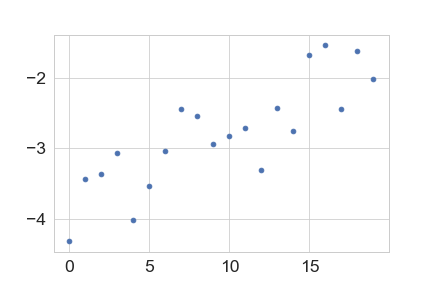

In [167]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,sqrt(sigma2),x.shape[0])
plt.scatter(x,y)

In [168]:
def calculateSquaredLoss(X,y,w):
    X1 = np.hstack([np.ones([X.shape[0],1]),X])
    ypred = np.dot(X1,w)
    return 0.5*np.sum(np.power(ypred - y,2))

In [169]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

-3.808 +  0.106 * X1


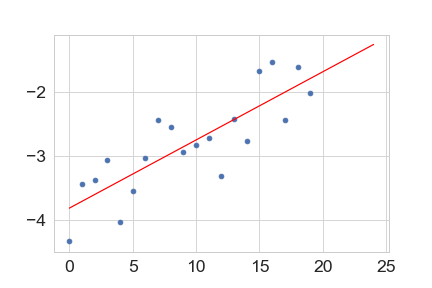

In [170]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest,ytest, color="red")

### Impact of outliers
OLE is susceptible to outliers because of the square term in the loss function. For Bayesian regression, the issue arises because of the square term in the pdf of the Gaussian distribution. See below for alternate distributions.

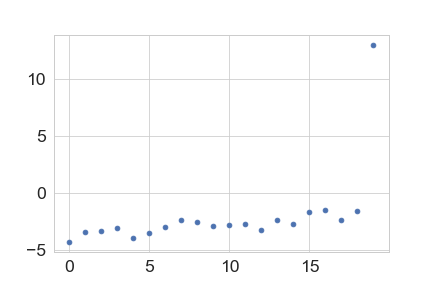

In [171]:
# adding outliers
y[19] = -3*y[0]
plt.scatter(x,y)

In [175]:
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))


-5.093 +  0.320 * X1


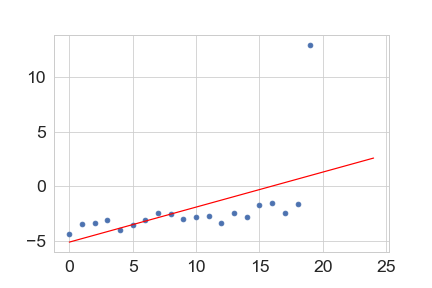

In [176]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = lr.predict(xtest)
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Using robust regression
The statsmodels package has a robust linear regression model function (rlm) 

In [177]:
import statsmodels.api as sm
x1 = np.transpose(np.vstack([np.ones(x.shape[0]),x.flatten()]))
# Fit model and print summary
rlm_model = sm.RLM(y, x1, M=sm.robust.norms.HuberT())
w = rlm_model.fit()
w =  w.params
print(pretty_print_linear(w[1:],w[0]))


-3.909 +  0.124 * X1


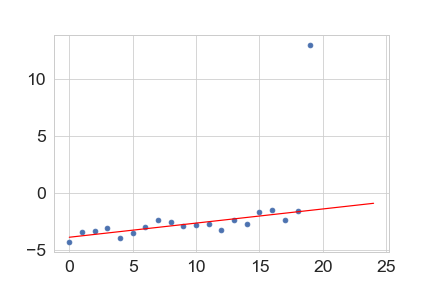

In [178]:
xtest = np.transpose(np.reshape(range(25),[1,len(range(25))]))
ytest = w[0] + w[1]*xtest
plt.scatter(x,y)
plt.plot(xtest, ytest, color="red")

### Handling outliers using other distributions
Below are some alternate distributions with less fat tail than Gaussian.

#### Laplace distribution
The distribution is defined using two parameters: $\mu$ and $b$. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{1}{2b}\exp\left(-\frac{\vert x - \mu\vert}{b}\right)$$

#### Student-t distribution
The distribution is defined using one parameter: $\nu$ or degrees of freedom. You can compute the <i>density</i> using the <b>probability density function</b>:
$$p(x) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu\pi}{\Gamma\left(\frac{\nu}{2}\right)}}\left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$


In [ ]:
# comparing student-t, norm, laplace
s = np.linspace(-10,10, 100)
df = 2.74335149908
plt.plot(s, laplace.pdf(s),'r-', lw=2, alpha=0.6, label='Laplace pdf')#assuming b = 1 and \mu = 0
#plt.plot(s, t.pdf(s,df),'b-', lw=2, alpha=0.6, label='Student-t pdf')#nu = df
plt.plot(s, norm.pdf(s,0,2),'k-', lw=2, alpha=0.6, label='Gaussian pdf')
plt.legend()

### Demonstrating Non-linear Regression
Also how to control the overfitting using Ridge Regression

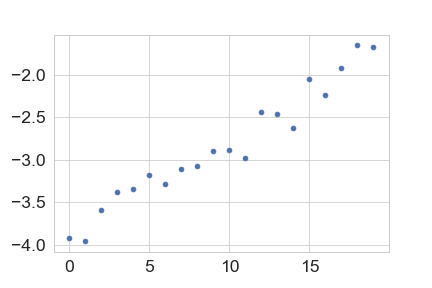

In [70]:
#generate some data
X = np.arange(20)
#X = X[:,np.newaxis]
w = np.array([-3.8,0.11])
y = w[0] + w[1]*X
sigma2 = 0.05
y = y + np.random.normal(0,sqrt(sigma2),X.shape[0])
plt.scatter(X,y)

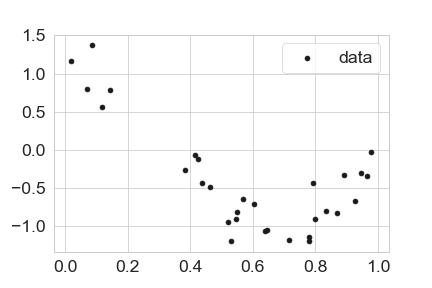

In [89]:
rng = np.random.RandomState(0)
# Generate sample data
np.random.seed(0)
n_samples = 30
true_fun = lambda X: np.cos(1.5 * np.pi * X)
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.2
X = X[:,np.newaxis]
plt.scatter(X,y, c='k', label='data')
plt.legend()

In [72]:
X2 = X**2
X3 = X**3
X4 = X**4
Xhat = np.hstack([X,X2,X3,X4])

In [26]:
lrmodel1 = LinearRegression()
lrmodel1.fit(X,y)
pretty_print_linear(lrmodel1.coef_,lrmodel1.intercept_)

' 0.588 + -1.714 * X1'

In [36]:
lrmodel2 = LinearRegression()
lrmodel2.fit(Xhat,y)
pretty_print_linear(lrmodel2.coef_,lrmodel2.intercept_)

' 1.115 + -0.607 * X1 + -13.005 * X2 + 15.814 * X3 + -3.270 * X4'

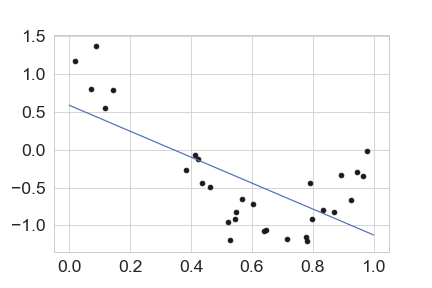

In [27]:
X_all = np.linspace(0, 1, 100)
X_all = X_all[:,np.newaxis]
y_all=lrmodel1.predict(X_all)
plt.plot(X_all,y_all)
plt.scatter(X,y, c='k', label='data')

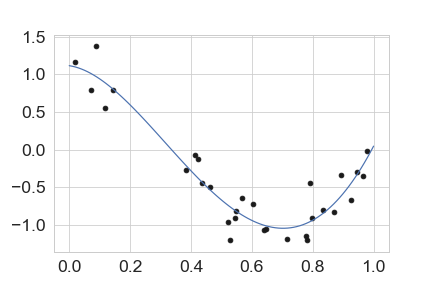

In [38]:
X_all2 = np.hstack([X_all,X_all**2,X_all**3,X_all**4])
y_all2=lrmodel2.predict(X_all2)
fig = plt.figure()
plt.plot(X_all,y_all2)
plt.scatter(X,y, c='k', label='data')

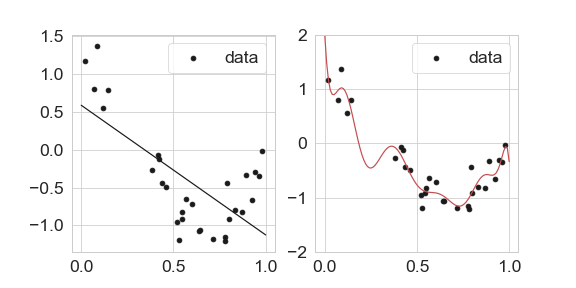

In [64]:
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=12,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)

# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
plt.ylim([-2,2])
plt.scatter(X,y, c='k', label='data')
plt.legend()

In [65]:
pretty_print_linear(lrmodel1.coef_,lrmodel1.intercept_)

' 2.003 + -60.474 * X1 + 1036.801 * X2 + -3999.849 * X3 + -54633.497 * X4 + 664421.839 * X5 + -3272753.343 * X6 + 9239878.572 * X7 + -16324304.555 * X8 + 18396505.038 * X9 + -12875298.497 * X10 + 5107851.959 * X11 + -878646.338 * X12'

In [61]:
cfs = lrmodel1.coef_
cfs[1:] = 0
lrmodel1.coef_ = cfs

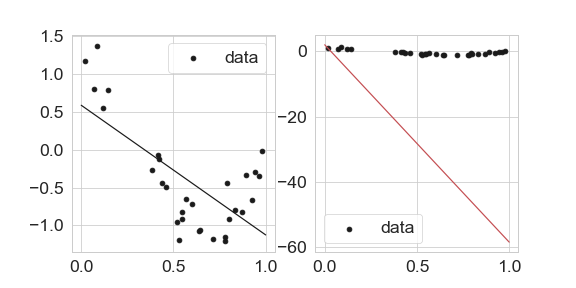

In [63]:
# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
#plt.ylim([-2,2])
plt.scatter(X,y, c='k', label='data')
plt.legend()

# Using Ridge Regression

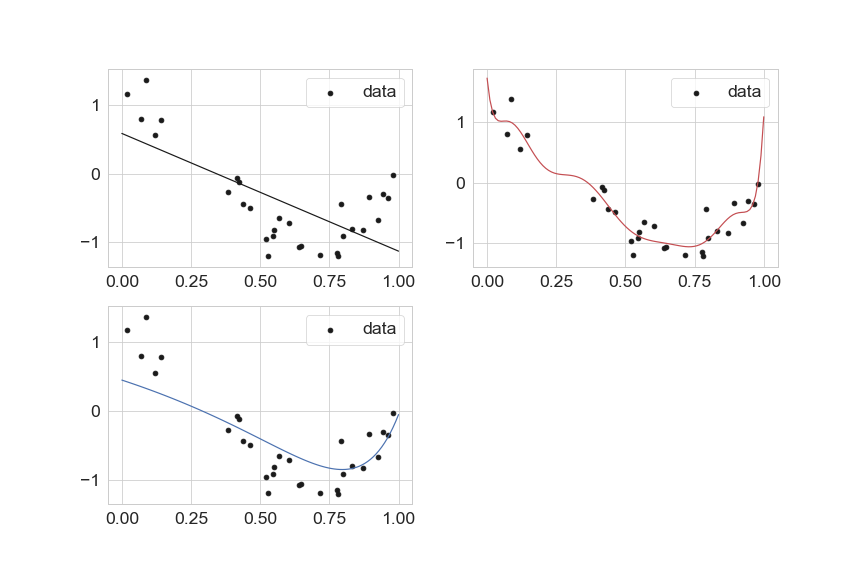

In [92]:
# Learn linear regression model
lrmodel = LinearRegression()
lrmodel.fit(X,y)
# Do polynomial basis expansion
polynomial_features = PolynomialFeatures(degree=10,include_bias=False)
# fit linear model on expanded features
lrmodel1 = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", lrmodel1)])
pipeline.fit(X,y)
# fit ridge regression model on expanded features
rrmodel = Ridge(alpha=1) # alpha is lambda
pipeline1 = Pipeline([("polynomial_features", polynomial_features),
                     ("ridge_regression", rrmodel)])
pipeline1.fit(X,y)

# plot the fitted lines
X_all = np.linspace(0, 1, 100)
fig = plt.figure(figsize=[12,8])
plt.subplot(2,2,1)
plt.plot(X_all, lrmodel.predict(X_all[:, np.newaxis]),color='k',label='')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,2)
plt.plot(X_all, pipeline.predict(X_all[:, np.newaxis]),color='r')
plt.scatter(X,y, c='k', label='data')
plt.legend()
plt.subplot(2,2,3)
plt.plot(X_all, pipeline1.predict(X_all[:, np.newaxis]),color='b')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Using Ridge Regression to Control Impact of correlated variables

In [75]:
np.random.seed(0)
size = 5000
 
#A dataset with 3 features
X = np.random.normal(0, 1, (size, 3))
#Y = X0 + 2*X1 + noise
Y = X[:,0] + 2*X[:,1] + np.random.normal(0, 2, size)
lr = LinearRegression()
lr.fit(X, Y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

 0.033 +  0.984 * X1 +  1.995 * X2 + -0.041 * X3


In [80]:
# adding correlated variables
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    lr = LinearRegression()
    lr.fit(X,Y)
    print("Linear model:", pretty_print_linear(lr.coef_,lr.intercept_))
 

Linear model: -0.184 + -0.047 * X1 +  1.312 * X2 +  1.621 * X3
Linear model: -0.018 +  0.747 * X1 +  1.109 * X2 +  1.079 * X3
Linear model:  0.251 + -0.098 * X1 +  1.049 * X2 +  1.940 * X3
Linear model: -0.145 +  1.348 * X1 +  1.636 * X2 +  0.039 * X3
Linear model:  0.093 +  0.957 * X1 +  1.637 * X2 +  0.391 * X3
Linear model:  0.149 +  0.764 * X1 +  0.698 * X2 +  1.569 * X3
Linear model:  0.013 +  1.425 * X1 +  1.720 * X2 + -0.071 * X3
Linear model: -0.128 +  2.004 * X1 +  1.464 * X2 + -0.658 * X3
Linear model:  0.045 + -0.640 * X1 +  0.738 * X2 +  2.955 * X3
Linear model:  0.009 +  2.016 * X1 + -0.784 * X2 +  1.828 * X3


In [87]:
# handling correlated variables through Ridge Regression
size = 100
X_seed = np.random.normal(0, 1, size)
for i in range(10):
    np.random.seed(seed=i)
    X1 = X_seed + np.random.normal(0, .1, size)
    X2 = X_seed + np.random.normal(0, .1, size)
    X3 = X_seed + np.random.normal(0, .1, size)
    Y = X1 + X2 + X3 + np.random.normal(0, 1, size)
    X = np.array([X1, X2, X3]).T
 
    ridge = Ridge(alpha=10)
    ridge.fit(X,Y)
    print("Ridge model:", pretty_print_linear(ridge.coef_,ridge.intercept_))


Ridge model: -0.084 +  0.221 * X1 +  0.221 * X2 +  0.219 * X3
Ridge model:  0.102 +  0.231 * X1 +  0.233 * X2 +  0.233 * X3
Ridge model:  0.333 +  0.226 * X1 +  0.221 * X2 +  0.223 * X3
Ridge model: -0.062 +  0.233 * X1 +  0.235 * X2 +  0.234 * X3
Ridge model:  0.207 +  0.228 * X1 +  0.230 * X2 +  0.229 * X3
Ridge model:  0.245 +  0.239 * X1 +  0.238 * X2 +  0.240 * X3
Ridge model:  0.112 +  0.246 * X1 +  0.249 * X2 +  0.244 * X3
Ridge model: -0.036 +  0.225 * X1 +  0.223 * X2 +  0.217 * X3
Ridge model:  0.124 +  0.236 * X1 +  0.242 * X2 +  0.241 * X3
Ridge model:  0.125 +  0.235 * X1 +  0.236 * X2 +  0.239 * X3


### Using LASSO to control overfitting

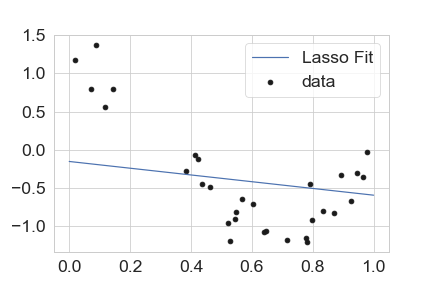

In [97]:
# fit LASSO on expanded features
llmodel = Lasso(alpha=0.1)
pipeline2 = Pipeline([("polynomial_features", polynomial_features),
                     ("lasso_regression", llmodel)])
pipeline2.fit(X,y)
# plot the fitted lines
X_all = np.linspace(0, 1, 100)
plt.plot(X_all, pipeline2.predict(X_all[:, np.newaxis]),label='Lasso Fit')
plt.scatter(X,y, c='k', label='data')
plt.legend()

### Demonstrating the role of Lasso in inducing sparsity
We will use the Boston housing data set to study this phenomenon

In [123]:
from sklearn.model_selection import cross_val_score

In [124]:
boston = load_boston()
scaler = StandardScaler()
X = scaler.fit_transform(boston["data"])
Y = boston["target"]
names = boston["feature_names"]

In [125]:
# fit linear regression
lrmodel = Ridge(alpha=0.1)
lrmodel.fit(X, Y)
scores = -np.mean(cross_val_score(lrmodel,
    X, Y, scoring="neg_mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
#print("Linear regression model: ", pretty_print_linear(lrmodel.coef_, lrmodel.intercept_, names, sort = True))

Cross validation error: 34.6897


In [127]:
lrmodel.coef_

array([-0.92730143,  1.08002721,  0.13847891,  0.68208866, -2.05390876,
        2.67510351,  0.01882112, -3.10135271,  2.65496439, -2.06996096,
       -2.05977302,  0.84922666, -3.74231919])

In [131]:
# fit Lasso
lasso = Lasso(alpha=0.8)
lasso.fit(X, Y)
scores = -np.mean(cross_val_score(lasso,
    X, Y, scoring="neg_mean_squared_error", cv=10))
print("Cross validation error: %.4f"%scores)
#print("Lasso model: ", pretty_print_linear(lasso.coef_, lasso.intercept_, names, sort = True))

Cross validation error: 36.8800


In [132]:
lasso.coef_

array([-0.        ,  0.        , -0.        ,  0.16807592, -0.        ,
        2.82375866, -0.        , -0.        , -0.        , -0.        ,
       -1.4461243 ,  0.32919048, -3.57391611])

In [134]:
names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

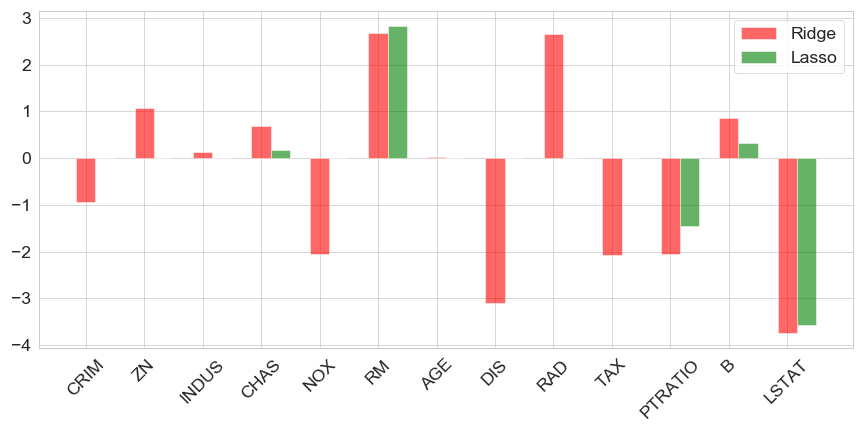

In [150]:
# comparing the two for sparsity
fig,ax = plt.subplots(1,1,figsize=[12,6])
plt.bar(range(1,len(lrmodel.coef_)+1),lrmodel.coef_,color='red',width=0.33,alpha=0.6)
plt.bar(np.arange(1.33,len(lrmodel.coef_)+1),lasso.coef_,color='green',width=0.33,alpha=0.6)
plt.legend(['Ridge', 'Lasso'])
xt = plt.xticks(range(1,len(lrmodel.coef_)+1),names,rotation=45)
plt.tight_layout()

# Comparing the objective functions 

In [204]:
# generate some data
Xraw = np.random.rand(100,2)
wtrue = np.array([[4],[2]])
y = np.dot(Xraw,wtrue)
X = Xraw + np.random.normal(0, 0.05, Xraw.shape)

In [205]:
# the squared loss function
def objfunction(w,X,y):
    J = 0.5*np.sum((y - np.dot(X,w))**2)
    return J

In [206]:
w1s = w2s = np.linspace(-20,20,100)
W1,W2 = np.meshgrid(w1s,w2s)

Js = []
for w1,w2 in zip(W1.flatten(),W2.flatten()):
    w = np.array([[w1],[w2]])
    Js.append(objfunction(w,X,y))
Js = np.array(Js)
Js = np.reshape(Js,W1.shape)

/Users/chandola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


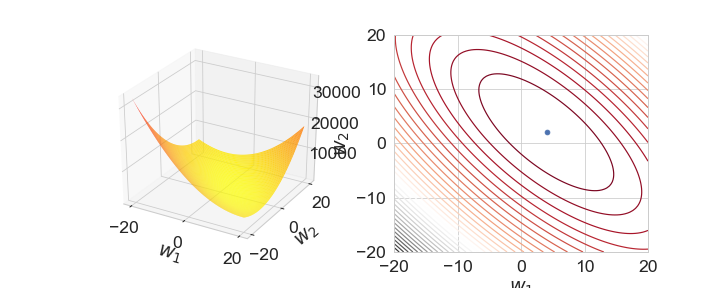

In [234]:
# plot the objective function
fig = plt.figure(figsize=(10,4))
grid = plt.GridSpec(1, 2, hspace=0.2, wspace=0.2)

ax = fig.add_subplot(grid[0,0:1],projection='3d')
ax.plot_surface(W1, W2, Js, rstride=1, cstride=1,
                cmap='autumn_r', edgecolor='none')
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

# plot the objective function in 2D
ax = fig.add_subplot(grid[0,1:2])
ax.contour(W1, W2, Js, 40, cmap='RdGy')
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.scatter([4],[2])

plt.tight_layout()


In [229]:
# plot the objective function for l1 and l2 regularization penalty
def l2penalty(w):
    return np.linalg.norm(w)**2

def l1penalty(w):
    return np.linalg.norm(w,ord=1)

In [230]:
l1pens = []
l2pens = []
for w1,w2 in zip(W1.flatten(),W2.flatten()):
    w = np.array([[w1],[w2]])
    l1pens.append(l1penalty(w))
    l2pens.append(l2penalty(w))
l1pens = np.array(l1pens)
l1pens = np.reshape(l1pens,W1.shape)
l2pens = np.array(l2pens)
l2pens = np.reshape(l2pens,W1.shape)

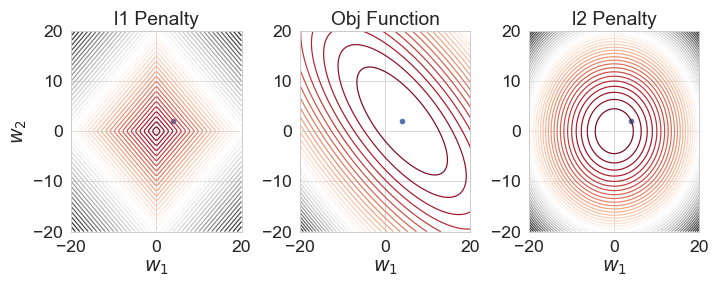

In [243]:
# plot the objective function with l1 and l2 penalty
fig,ax = plt.subplots(1,3,figsize=(10,4),sharex='col')
ax[0].contour(W1, W2, l1pens, 40, cmap='RdGy')
ax[0].set_xlabel('$w_1$')
ax[0].set_ylabel('$w_2$')
ax[0].scatter([4],[2])
ax[0].set_title('l1 Penalty')

ax[1].contour(W1, W2, Js, 40, cmap='RdGy')
ax[1].set_xlabel('$w_1$')
ax[1].scatter([4],[2])
ax[1].set_title('Obj Function')



ax[2].contour(W1, W2, l2pens, 40, cmap='RdGy')
ax[2].set_xlabel('$w_1$')
ax[2].scatter([4],[2])
ax[2].set_title('l2 Penalty')



plt.tight_layout()



## Bayesian Linear Regression
Impact of prior on the posterior estimate

In [3]:
from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LinearRegression

In [4]:
def bayesRegFit(X,y,tausquared):
    '''
    Imposes a prior ~ N(0,tausquared*I). Estimates sigmasquared from the data. Does not treat that as a random variable.
    '''
    N = X.shape[0]
    ols = LinearRegression(fit_intercept=False)
    ols.fit(X, y)
    diff = y - np.dot(X,ols.coef_.T)
    sigmasquared = (1/N)*np.dot(diff.T,diff)
    XTX = np.dot(X.T,X)
    inv = np.linalg.inv(XTX + (sigmasquared/tausquared)*np.eye(X.shape[1]))
    w = np.dot(inv,np.dot(X.T,y))
    Sigma = sigmasquared*inv
    return w,Sigma
    

In [5]:
def plot_contours(ax,mean,cov,cm='Reds',levels=6):
    w1s = w2s = np.linspace(-10,10,100)
    W1,W2 = np.meshgrid(w1s,w2s)

    pdfs = []
    for w1,w2 in zip(W1.flatten(),W2.flatten()):
        w = np.array([w1,w2])
        pdfs.append(mvn.pdf(w,mean,cov))
    pdfs = np.array(pdfs)
    pdfs = np.reshape(pdfs,W1.shape)

    cfset = ax.contourf(W1, W2, pdfs, levels=levels,cmap=cm)
    cset = ax.contour(W1, W2, pdfs, levels=levels, colors='k',alpha=0.6)
    ax.clabel(cset, inline=1, fontsize=10)

In [6]:
# generate some data
Xraw = np.random.rand(100,2)
wtrue = np.array([[8],[4]])
y = np.dot(Xraw,wtrue)
X = Xraw + np.random.normal(0, 0.1, Xraw.shape)

In [7]:
# assume a Gaussian prior on w
prior_mean = np.zeros((2,))
tausquared = 0.1
prior_cov = tausquared*np.eye(2)

Text(-6.0, -4.0, 'Prior mean')

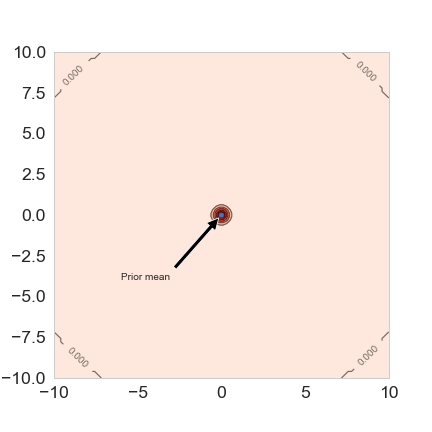

In [8]:
# plot the prior distribution
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

plot_contours(ax,prior_mean,prior_cov)
ax.scatter(prior_mean[0],prior_mean[1])
ax.annotate('Prior mean', xy=(prior_mean[0],prior_mean[1]), xytext=(prior_mean[0]-6,prior_mean[1]-4),
            arrowprops=dict(facecolor='black', shrink=0.05))

In [9]:
# find the MLE estimate
ols = LinearRegression(fit_intercept=False)
ols.fit(X, y)
print(ols.coef_[0])

[7.87858075 3.86204582]


Text(2.8785807452916172, 6.862045819175242, 'MLE Estimate')

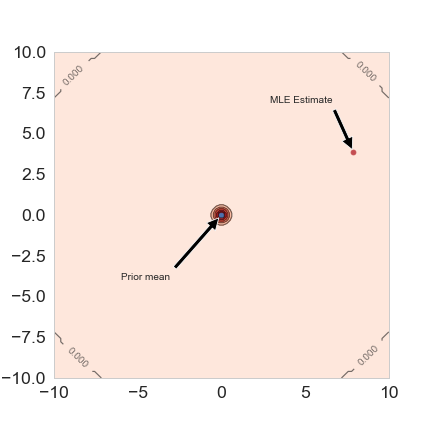

In [10]:
# plot the prior distribution + MLE
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

plot_contours(ax,prior_mean,prior_cov)
ax.scatter(prior_mean[0],prior_mean[1])
ax.annotate('Prior mean', xy=(prior_mean[0],prior_mean[1]), xytext=(prior_mean[0]-6,prior_mean[1]-4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(ols.coef_[0,0],ols.coef_[0,1],c='r',s=24)
ax.annotate('MLE Estimate', xy=(ols.coef_[0,0],ols.coef_[0,1]), 
            xytext=(ols.coef_[0,0]-5,ols.coef_[0,1]+3),
            arrowprops=dict(facecolor='black', shrink=0.05))

In [11]:
w_bayes,Sigma_bayes = bayesRegFit(X,y,tausquared)

In [12]:
print(w_bayes)
print(Sigma_bayes)

[[6.30827156]
 [4.18025411]]
[[ 0.0281512  -0.01676847]
 [-0.01676847  0.02596834]]


Text(-1.6917284378866562, 5.1802541120485195, 'Posterior Mean')

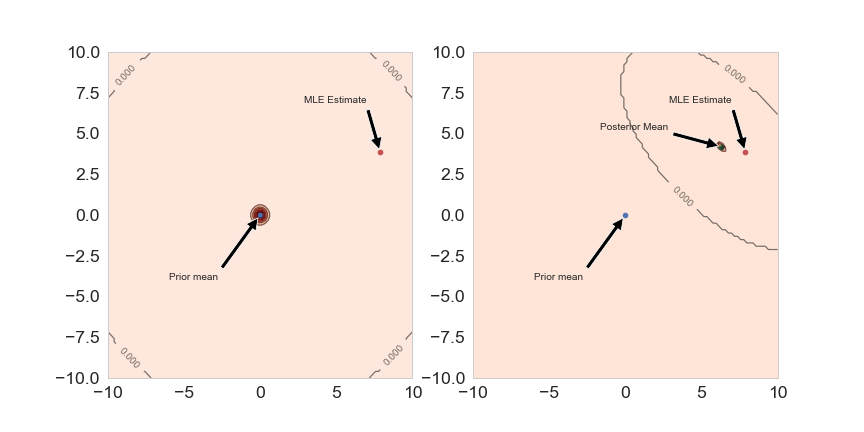

In [14]:
# plot the prior distribution + MLE
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)

plot_contours(ax,prior_mean,prior_cov)
ax.scatter(prior_mean[0],prior_mean[1])
ax.annotate('Prior mean', xy=(prior_mean[0],prior_mean[1]), xytext=(prior_mean[0]-6,prior_mean[1]-4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(ols.coef_[0,0],ols.coef_[0,1],c='r',s=24)
ax.annotate('MLE Estimate', xy=(ols.coef_[0,0],ols.coef_[0,1]), 
            xytext=(ols.coef_[0,0]-5,ols.coef_[0,1]+3),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax = plt.subplot(122)
plot_contours(ax,w_bayes.flatten(),Sigma_bayes,levels=4)
ax.scatter(prior_mean[0],prior_mean[1])
ax.annotate('Prior mean', xy=(prior_mean[0],prior_mean[1]), xytext=(prior_mean[0]-6,prior_mean[1]-4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(ols.coef_[0,0],ols.coef_[0,1],c='r',s=24)
ax.annotate('MLE Estimate', xy=(ols.coef_[0,0],ols.coef_[0,1]), 
            xytext=(ols.coef_[0,0]-5,ols.coef_[0,1]+3),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(w_bayes[0,0],w_bayes[1,0],c='g',s=24)
ax.annotate('Posterior Mean', xy=(w_bayes[0,0],w_bayes[1,0]), 
            xytext=(w_bayes[0,0]-8,w_bayes[1,0]+1),
            arrowprops=dict(facecolor='black', shrink=0.05))
